In [1]:
#basic importing
import os
import sys
path1=sys.path.append('/u/vasulkar/p_emodnet_amey/Regional_canada_model/')
from IPython.display import Image
from IPython.core.display import HTML 
# Image("sea_ice_division.jpg")

# Introduction
The sea ice cover is divided in three parts.

<!-- ![title](sea_ice_division.jpg) -->
<img src="sea_ice_division.jpg" width="900"/>


Assuming the drifting sea ice and water as one integrated layer. The momentum equatio for the integrated layer is given by:
$$\frac{\partial u}{\partial t}+f\times u +\frac{(u. \partial)u}{h}=-g\nabla(\zeta)+\nabla.(\tilde{\nu}(\nabla u + \nabla u^T))+\frac{\rho_w \tilde{C_w}u|u|}{h}+\frac{\tau_{IT}}{h}, $$
where $\tilde{\nu}$ is the effective viscosity of the ice-ocean layer and $\tilde{C_w}=C_w+C_i$ with $C_w$ being the bottom friction coefficient and $C_i$ is the drag coefficient between fast ice and ocean. 
 
The idea is to optimize the effective viscosity parameter in the region of the sea ice cover. Now, we can only have a certain number of parameters so the region of sea ice cover has to be discretized and each point in the discretized domain acts as a parameter. But this is not possible realistically as we will have a lot of parameters than observations. So, the idea here is to analyse the domain and use physics to determine how the sea ice cover can be divided. The division of the sea ice cover will give us the number of parameters and their distribution. For this, we use the energy loss from the viscous shear as a parameter to judge in the domain where the energy loss to viscous shear is high and important. 


# Smagorinsky Model
For this, in dflowfm there is not direct way to compute the viscous shear. So we impose aa smagorinsky turbulence model in the computations.
The model states that the residual viscous shear to close the N-S equations is given by:
$$\tau^r=-2\nu_r \bar{S},$$
where $\nu_r$ is the residual effective viscosity and $\bar{S}$ is the Strain Rate. Now in DFlow-FM the effective viscosity map is available and it is computed as:
$$\nu_r=\nu_i+((C_sdx)^2)\bar{S},$$
where $\nu_i(=25)$ is the initial viscosity used in our model, $C_s$ is the Smagorinsky coefficient, $dx$ is the grid step. 

Now, the viscous shear stress is given by:
$$\tau_v=2\nu \partial S. $$
Then, assumeing $C_s=1$, we can use the viscosity output ($\nu_r$) from the model to compute the partial derivative of shear strain as:
$$\bar{S}dx^2=\nu_r-\nu$$




Based on the above analysis, it seems difficult to use the idea. but just plotting the residual viscosity can give some idea for creating boxes. WE will come to that late. Now the idea from now on is, re-calibrate the bottom friction and bathymetry in canada region for september with some const effective visosity for sea ice. For that purpose, we have to divide the canadma model region in some regions for bathymetry and bottom friction. In this light, the first step is to get the region of canada model have. 

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon, shape
import shapefile

import cartopy.crs as ccrs
import cartopy.feature as cpf 
from global_land_mask import globe
import pandas as pd

In [5]:
#reading the canadamodel net file 
netfile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/third_model_files/gtsm__canada_2_net.nc'
netdf=xr.open_dataset(netfile)
netdf

<xarray.Dataset>
Dimensions:      (nNetLink: 560343, nNetLinkPts: 2, nNetNode: 278376)
Coordinates:
    NetNode_x    (nNetNode) float64 ...
    NetNode_y    (nNetNode) float64 ...
Dimensions without coordinates: nNetLink, nNetLinkPts, nNetNode
Data variables:
    Mesh2D       int32 ...
    wgs84        int32 ...
    NetNode_z    (nNetNode) float64 ...
    NetLink      (nNetLink, nNetLinkPts) int32 ...
    NetLinkType  (nNetLink) int32 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.59.64338M, Jul 19 2019, 1...
    history:        Created on 2021-07-21T17:40:42+0200, D-Flow FM
    date_created:   2021-07-21T17:40:42+0200
    date_modified:  2021-07-21T17:40:42+0200
    Conventions:    UGRID-0.9

In [6]:
nodelon=netdf.NetNode_x.values
nodelat=netdf.NetNode_y.values
#gettting a polygon from max and min lon lat to insert points.
lonmin=nodelon.min();lonmax=nodelon.max() #latmin is subtracted by 0.5deg to accomodate the southmost portion of HB
latmin=nodelat.min()-0.5;latmax=nodelat.max()
coords=[(lonmin, latmin), (lonmin,latmax), (lonmax,latmax), (lonmax, latmin),(lonmin, latmin)]
poly = Polygon(coords)
netdf.close()

Now we try to insert a bunch of points.

The below is a conversion of fibonacci grid code from cornelis in matlab. 

In [17]:
def Fibonacci_grid(P):
    '''
    Construct Fibonacci grid, see Swinbank & Purser, Fibonacci grids: A novel approach to
    global modelling. Q.J.R. Meteorol. Soc. (2006), 132 : 1769-1793, doi:10.1256/qj.05.227
    Input: 
    P = (preliminary) number of Fibonacci grid points; 
    The Fibonacci grid parameter is then computed as N = (P-1)/2 if P is odd.
    If P is even, we use the equation N = P/2.     
    The final number of Fibonacci points is equal to 2N+1
    Output:
     -lon = longitude [degrees] in interval [-180;180] (spherical coordinates)
     -lat = latitude [degrees] (spherical coordinates)
    '''  
    # Settings
    # N=int(7000)
    # Golden Ration
    Phi=(1+np.sqrt(5))/2
    #fibonacci grid parameter
    N = (P - np.remainder(P,2))/2
    #Compute lat and lon
    Nvec=np.arange(-N,N+1,1)
    Nvc=Nvec.reshape((len(Nvec),1))
    lat = np.arcsin((2*Nvec)/(2*N+1))*(180/np.pi)
    #lon from -180 to 180 and 0 to 360 is different
    lon = np.remainder(360*Nvec/Phi,360)   #this provides longitudes over [0,360]
    lon=lonunwrap(lon)
    return(lon,lat)

def lonunwrap(lon360):
    lon180=(lon360+180.0) %360.0 -180
    return(lon180)

In [18]:
lon1,lat1=Fibonacci_grid(42000)

The ideal grid is fibonacci. So the below idea is probably not as good. especially for plotting.

In [80]:
#per lon deg we have around 2 points and per lat deg 8 points.
Nlat=np.floor(abs((latmax-latmin)*1)).astype(int)
Nlon=np.floor(abs((lonmax-lonmin)*0.25)).astype(int)
latpointvec=np.linspace(latmin,latmax,Nlat)
lonpointvec=np.linspace(lonmin,lonmax,Nlon)
lonpointgrid,latpointgrid=np.meshgrid(lonpointvec,latpointvec)

In [26]:
#using the fibonaaci grid. We obtain the points in our domain of canada region.
fibloncanvec=[]
fiblatcanvec=[]
for i in range(len(lon1)):
    loni=lon1[i]
    lati=lat1[i]
    if (lonmin-1.0)<=loni<=(lonmax+1.0) and latmin<=lati<=(latmax+1.0):
        fibloncanvec=np.append(fibloncanvec,loni)
        fiblatcanvec=np.append(fiblatcanvec,lati)



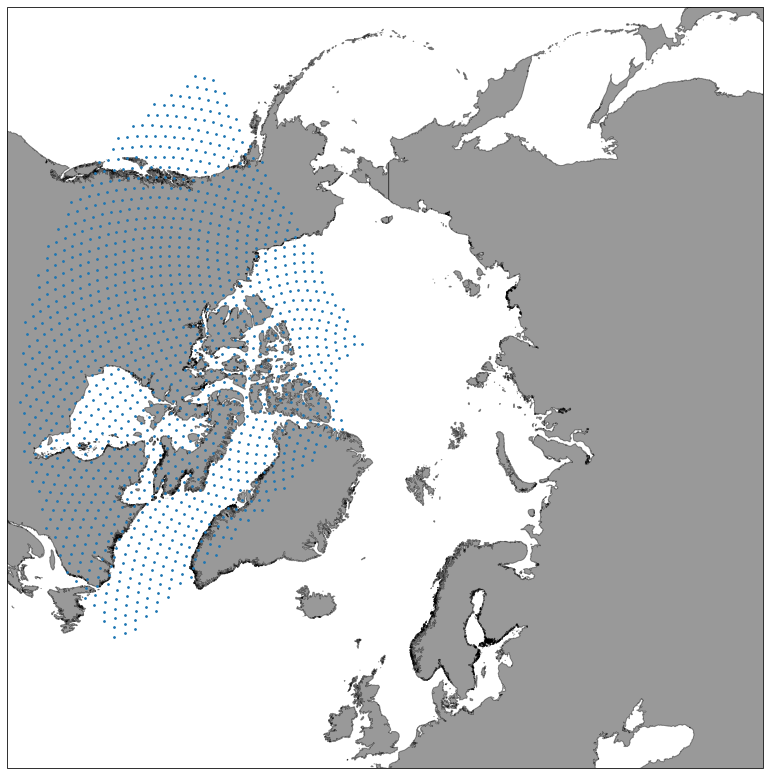

In [27]:
# marking the x-axis and y-axis 
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
# ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
ax1.set_extent((-180.0, 180.0, 49, 90.0), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
ax1.add_feature(feature)
# ax1.add_geometries([poly], crs=ccrs.PlateCarree(),  edgecolor='red', facecolor='None',alpha=1)
ax1.scatter(fibloncanvec,fiblatcanvec,transform=ccrs.PlateCarree(),s=3)

plt.show()

instead of taking points only in ocean like we did before. Now we take points only in the domain. so the .xyz file has all the points in the caanda domain. 

In [1]:
#Removed below portion as it was checking points if they were in ocean or not.
# is_in_ocean = globe.is_ocean(latpointgrid, lonpointgrid)
# index=np.where(is_in_ocean.ravel()==True)
# oceanpointlonvec=lonpointgrid.ravel()[index]
# oceanpointlatvec=latpointgrid.ravel()[index]
# marking the x-axis and y-axis 
# fig=plt.figure(figsize=(20, 14), frameon=True)
# proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
# ax1=fig.add_subplot(1,1,1,projection=proj) 
# ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())

# feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
# ax1.add_feature(feature)
# ax1.add_geometries([poly], crs=ccrs.PlateCarree(),  edgecolor='red', facecolor='None',alpha=1)
# ax1.scatter(oceanpointlonvec,oceanpointlatvec,transform=ccrs.PlateCarree(),s=0.1)

# plt.show()

Now, we create temporary .xyz file from this, import in interactor and remove the poiints outside our grid. 

In [28]:
# vec=np.vstack((oceanpointlonvec,oceanpointlatvec))
vec=np.vstack((fibloncanvec,fiblatcanvec))
# paraidvec=1*(np.ones(len(oceanpointlonvec))).astype(int)
paraidvec=1*(np.ones(len(fibloncanvec))).astype(int)
vec=np.vstack((vec,paraidvec.reshape((1,len(paraidvec)))))
np.savetxt('initia_points_fib.xyz',vec.T,fmt=['%0.5f','%0.5f','%d'],delimiter='\t')
#updated it in interactor and obtained file by name of modelpoints_**.xyz


Once the above file is obtained we do not have to run the codes above we acan directly start below.

In [3]:
fname='modelpoints_fb.xyz'
headerlist=['Lon','Lat','pname']
df=pd.read_csv(fname,names=headerlist,delim_whitespace=True)
df.head()

Lon       Lat  pname
0 -80.35835  50.24973    1.0
1 -78.54935  50.63100    1.0
2 -81.47638  50.86816    1.0
3 -79.66738  51.25452    1.0
4 -47.20620  51.27632    1.0

In [4]:
modoceanlonpointvec=np.array(df['Lon'])
modoceanlatpointvec=np.array(df['Lat'])

In [9]:
# The below was the initial idea which we used to create a bunch of points and make polygons from them,
#polygon point vec. to make parameters.
#per lon deg we have around 2 points and per lat deg 8 points.
#per lon deg we have around 2 points and per lat deg 8 points.

# Nlat=np.floor(abs((latmax-latmin)*8)).astype(int)
# Nlon=np.floor(abs((lonmax-lonmin)*2)).astype(int)
# latpointvec=np.linspace(latmin,latmax,Nlat)
# lonpointvec=np.linspace(lonmin,lonmax,Nlon)
# pollatvec=latpointvec[::5];pollonvec=lonpointvec[::2]
# polydict={}
# k=1
# i=0
# float_formatter = "{:.2f}".format
# while i<=(len(lonpointvec)-6):
#     # print(i)
#     j=0
#     while j<=(len(latpointvec)-3):
        
#         coords=[(lonpointvec[i], latpointvec[j]), (lonpointvec[i],latpointvec[j+2]), (lonpointvec[i+5],latpointvec[j+2]), (lonpointvec[i+5],latpointvec[j]),(lonpointvec[i],latpointvec[j])]
#         npcoords=np.array(coords)
        
#         for elem in npcoords:
#             elem1=float(float_formatter(elem[0]))
#             elem2=float(float_formatter(elem[1]))
#             if  elem1 in modoceanlonpointvec:
#                 index=np.where(modoceanlonpointvec==elem1)
#                 for ind in index[0]: 
#                     # print(i)      
#                     if modoceanlatpointvec[ind]==elem2:
#                         poly=Polygon(coords)
#                         print(k)
#                         polydict[k]=poly 
#                         k+=1
#                         break
#             break
#         j=j+3       
        
#     i=i+6
# marking the x-axis and y-axis  

# fig=plt.figure(figsize=(20, 14), frameon=True)
# # proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
# proj=ccrs.PlateCarree()
# ax1=fig.add_subplot(1,1,1,projection=proj) 
# ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# # ax1.set_extent((-60, -55, 49, 84), crs=ccrs.PlateCarree())
# feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
# ax1.add_feature(feature)
# # ax1.add_geometries([poly], crs=ccrs.PlateCarree(),  edgecolor='red', facecolor='None',alpha=1)
# ax1.scatter(modoceanlonpointvec,modoceanlatpointvec,transform=ccrs.PlateCarree(),s=0.1)
# for keys in polydict:
#     ax1.add_geometries([polydict[keys]],crs=ccrs.PlateCarree(),edgecolor='red',facecolor='None')
    
# plt.show()

Now the below logic is for polygons made in Qgis based on a certain understanding and guess of the dynamics in the region for the bottom friction and bathymetry,

In [8]:
#reading a polygon vertices file. 
# we divide the domain into 17 polyogons. 
# poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/Polygon_crreation/PolVertices_2.csv')
poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bathy_polygon/bahy_polygon_vertices_v3.csv')
poldf.head()

X     Y  id  vertex_index  vertex_part  vertex_part_ring  \
0 -83.0  54.6  14             0            0                 0   
1 -83.0  50.5  14             1            0                 0   
2 -77.0  50.5  14             2            0                 0   
3 -77.0  54.6  14             3            0                 0   
4 -83.0  54.6  14             4            0                 0   

   vertex_part_index  distance  angle  
0                  0       0.0  225.0  
1                  1       4.1  135.0  
2                  2      10.1   45.0  
3                  3      14.2  315.0  
4                  4      20.2  225.0

In [6]:
poldf.id.values

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17,
       17, 17, 17, 17, 17, 17])

In [9]:
Npol=17
Lonvec=poldf['X']
Latvec=np.array(poldf['Y'])
# Latvec[78]=72.0  ##it was 72.0033 changed as it is wrong in excel file
# Latvec=np.where(Latvec==84,84.5,Latvec) ##points added till 84.3
# Lonvec=np.where(Lonvec==-46.5,-46.0,Lonvec)
idvec=poldf['id']
vindexvec=poldf['vertex_index']
polydict={}
for id in range(Npol):
    id=id+1 #as the ids start from 1
    idindex=np.where(idvec==id)[0]
    coords=[]
    for i in range(len(idindex)):
        coords.append((Lonvec[idindex[i]],Latvec[idindex[i]]))
    poly=Polygon(coords)
    polydict[id]=poly
    

In [10]:
#check if a point lies in a polygon. If so, assign the point a value of parameter corresponding to polygon id. 
paramid=[]
for i in range(len(modoceanlatpointvec)):
    point=Point(modoceanlonpointvec[i],modoceanlatpointvec[i])
    count=0
    for keys in polydict:
        poly=polydict[keys]
        if poly.contains(point):
            paramid=np.append(paramid,keys)
            count=1
    if count==0:
        paramid=np.append(paramid,100)
        print('Point not contained in any polyon')
        print(point)
        
        
    

Point not contained in any polyon
POINT (-80.35835 50.24973)
Point not contained in any polyon
POINT (-47.2062 51.27632)
Point not contained in any polyon
POINT (-54.86924 51.368)
Point not contained in any polyon
POINT (-50.13322 51.51682)
Point not contained in any polyon
POINT (-53.06024 51.7586)
Point not contained in any polyon
POINT (-48.32422 51.90872)
Point not contained in any polyon
POINT (-55.98726 52.00168)
Point not contained in any polyon
POINT (-83.71241999999999 52.13039)
Point not contained in any polyon
POINT (-51.25124 52.15262)
Point not contained in any polyon
POINT (-46.51522 52.30406)
Point not contained in any polyon
POINT (-54.17826 52.39786)
Point not contained in any polyon
POINT (-49.44224 52.55015)
Point not contained in any polyon
POINT (-57.10529 52.64447)
Point not contained in any polyon
POINT (-84.83044 52.77507)
Point not contained in any polyon
POINT (-52.36926 52.79762)
Point not contained in any polyon
POINT (-60.03231 52.89249)
Point not contained

In [11]:
fname='bathy_correction_template_'+str(Npol)+'_v3.xyz'
sortind=np.argsort(paramid) #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((modoceanlonpointvec[sortind],modoceanlatpointvec[sortind]))
vec=np.vstack((vec,paramid[sortind].reshape((1,len(paramid)))))
# vec=vec[:,:-2]#removing the last point. as it is outside . point 100.
paravec=vec[2,:]
inpolindex=np.where(paravec!=100) [0]
vec=vec[:,inpolindex]
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%d'],delimiter='\t')


[[-83.18456 -80.52147 -79.13952 -86.80256 -94.46561 -82.06654 -89.72958
  -91.53858 -77.33052 -92.65661 -80.25754 -87.92058 -90.84761 -78.44854
  -79.83049 -84.99356 -88.18451 -83.87554 -76.21249 -92.22956 -82.75752
  -84.56652 -76.90347 -90.42056 -89.30254 -78.02149 -81.63949 -85.68454
  -86.37551 -93.34758 -78.71247 -80.94852 -88.61156 -83.44849 -93.77463
  -81.37556 -86.11159 -76.63954 -89.03861 -77.75756 -90.15663 -82.49359
  -94.89265 -87.49354 -79.56656 -91.96563 -84.30259 -87.22961 -92.39268
  -95.3197  -94.20168 -91.27465 -90.58368 -93.5107  -91.7017  -94.62872
  -92.81972 -93.93775 -93.08365 -91.01073 -89.62877 -86.70175 -87.1288
  -88.51075 -87.81977 -87.39273 -86.01077 -88.9378  -87.65666 -89.46565
  -89.20173 -88.34763 -85.84766 -86.2747  -88.77468 -86.96568 -89.8927
  -86.53863 -88.0837  -84.72963 -81.53868 -83.61161 -81.80261 -82.92063
  -83.34768 -85.42061 -82.22966 -85.15668 -84.03866 -87.55584 -91.17384
  -88.24682 -89.36484 -85.74684 -91.60089 -88.67387 -94.10087 -93.

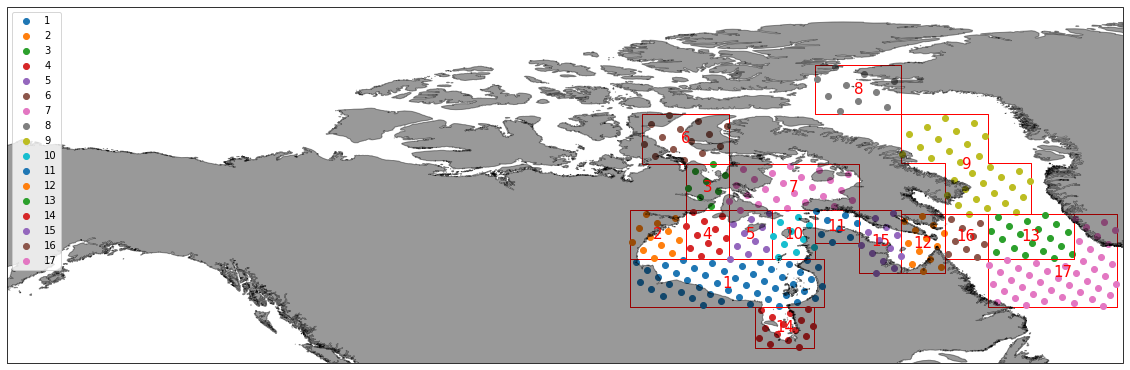

In [12]:
# marking the x-axis and y-axis  

fig=plt.figure(figsize=(20, 14), frameon=True)
# proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
proj=ccrs.PlateCarree()
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -46, 49, 84.7), crs=ccrs.PlateCarree())
# ax1.set_extent((-60, -55, 49, 84), crs=ccrs.PlateCarree())

# ax1.add_geometries([poly], crs=ccrs.PlateCarree(),  edgecolor='red', facecolor='None',alpha=1)
# ax1.scatter(modoceanlonpointvec,modoceanlatpointvec,transform=ccrs.PlateCarree(),s=3)

# cont1=ax1.scatter(vec[0,:],vec[1,:],c=vec[2,:],transform=ccrs.PlateCarree(),cmap='viridis',marker='o',vmin=1,vmax=17)
# cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
for keys in polydict:
    ax1.add_geometries([polydict[keys]],crs=ccrs.PlateCarree(),edgecolor='red',facecolor='None',label=keys)
    x=polydict[keys].centroid.x
    y=polydict[keys].centroid.y
    ax1.text(x, y, keys, color='red', size=15, ha='center', va='center', transform=ccrs.PlateCarree())
    #getting points in polygon. from paramid.
    indparam=np.where(vec[2,:]==keys)[0]
    print(vec)
    ax1.scatter(vec[0,indparam],vec[1,indparam],transform=ccrs.PlateCarree(),label=str(keys))

ax1.legend()

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
ax1.add_feature(feature)
    
plt.show()

In [13]:
fname='bathy_correction_'+str(Npol)+'_v3.xyz'
sortind=np.argsort(paramid) #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((modoceanlonpointvec[sortind],modoceanlatpointvec[sortind]))
vec=np.vstack((vec,paramid[sortind].reshape((1,len(paramid)))))
vec=vec[:,:-2]#removing the last point. as it is outside . point 100.
# vec=vec[:,:-2]#removing the last point. as it is outside . point 100.
paravec=vec[2,:]
inpolindex=np.where(paravec!=100) [0]
vec=vec[:,inpolindex]
vec[2,:]=1.0 #starting with 1.0 as the multiplier.

np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%0.3f'],delimiter='\t')

creating polygon and points .xyz file similar to bathymetry for bottom friction

In [8]:
#reading a polygon vertices file. 
# we divide the domain into 17 polyogons. 
# poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/bf_polygon/bfpolygonveritces_2.csv')
poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bf_polygon/bf_polygon_vertices.csv')
poldf.head()

X     Y  id  vertex_index  vertex_part  vertex_part_ring  \
0 -57.5  83.5  16             0            0                 0   
1 -57.5  77.0  16             1            0                 0   
2 -78.0  77.0  16             2            0                 0   
3 -78.0  83.5  16             3            0                 0   
4 -57.5  83.5  16             4            0                 0   

   vertex_part_index  distance  angle  
0                  0       0.0  135.0  
1                  1       6.5  225.0  
2                  2      27.0  315.0  
3                  3      33.5   45.0  
4                  4      54.0  135.0

In [17]:
poldf.id.values

array([16, 16, 16, 16, 16,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15])

In [18]:
Npol=16
Lonvec=poldf['X']
Latvec=np.array(poldf['Y'])
# Latvec[78]=72.0  ##it was 72.0033 changed as it is wrong in excel file
# Latvec=np.where(Latvec==84,84.5,Latvec) ##points added till 84.3
# Lonvec=np.where(Lonvec==-46.5,-46.0,Lonvec)
idvec=poldf['id']
vindexvec=poldf['vertex_index']
polydict={}
for id in range(Npol):
    id=id+1 #as the ids start from 1
    idindex=np.where(idvec==id)[0]
    coords=[]
    for i in range(len(idindex)):
        coords.append((Lonvec[idindex[i]],Latvec[idindex[i]]))
    poly=Polygon(coords)
    polydict[id]=poly
    

In [19]:
#check if a point lies in a polygon. If so, assign the point a value of parameter corresponding to polygon id. 
paramid=[]
for i in range(len(modoceanlatpointvec)):
    point=Point(modoceanlonpointvec[i],modoceanlatpointvec[i])
    count=0
    for keys in polydict:
        poly=polydict[keys]
        if poly.contains(point):
            paramid=np.append(paramid,keys)
            count=1
    if count==0:
        paramid=np.append(paramid,100)
        print('Point not contained in any polyon')
        print(point)

Point not contained in any polyon
POINT (-80.35835 50.24973)
Point not contained in any polyon
POINT (-78.54935 50.631)
Point not contained in any polyon
POINT (-81.47638000000001 50.86816)
Point not contained in any polyon
POINT (-47.2062 51.27632)
Point not contained in any polyon
POINT (-54.86924 51.368)
Point not contained in any polyon
POINT (-50.13322 51.51682)
Point not contained in any polyon
POINT (-77.85838 51.64415)
Point not contained in any polyon
POINT (-53.06024 51.7586)
Point not contained in any polyon
POINT (-48.32422 51.90872)
Point not contained in any polyon
POINT (-55.98726 52.00168)
Point not contained in any polyon
POINT (-51.25124 52.15262)
Point not contained in any polyon
POINT (-46.51522 52.30406)
Point not contained in any polyon
POINT (-54.17826 52.39786)
Point not contained in any polyon
POINT (-49.44224 52.55015)
Point not contained in any polyon
POINT (-57.10529 52.64447)
Point not contained in any polyon
POINT (-77.1674 52.68046)
Point not contained in

In [21]:
fname='bf_correction_template_'+str(Npol)+'_v3.xyz'
sortind=np.argsort(paramid) #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((modoceanlonpointvec[sortind],modoceanlatpointvec[sortind]))
vec=np.vstack((vec,paramid[sortind].reshape((1,len(paramid)))))
#non 100 param value
paravec=vec[2,:]
inpolindex=np.where(paravec!=100) [0]
vec=vec[:,inpolindex]#removing the last point. as it is outside . point 100.
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%d'],delimiter='\t')

In [13]:
vec[2,:]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,
        9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 11., 11.,
       11., 11., 11., 11., 11., 11., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 13., 13., 13., 13., 13., 13

[[-91.27465 -91.7017  -93.5107  -91.01073 -90.84761 -90.58368 -93.93775
  -92.39268 -94.20168 -90.42056 -93.34758 -92.81972 -93.08365 -91.53858
  -90.15663 -94.62872 -93.77463 -92.65661 -94.89265 -91.96563 -94.46561
  -87.81977 -87.1288  -89.62877 -87.39273 -86.70175 -88.9378  -88.51075
  -86.01077 -86.96568 -86.11159 -88.77468 -87.92058 -89.03861 -86.37551
  -89.46565 -87.65666 -87.49354 -86.80256 -89.72958 -86.53863 -85.68454
  -87.22961 -88.61156 -88.34763 -89.30254 -89.8927  -85.84766 -89.20173
  -88.0837  -86.2747  -83.87554 -83.61161 -82.49359 -82.06654 -82.75752
  -81.80261 -84.72963 -84.99356 -84.56652 -84.30259 -81.53868 -82.92063
  -81.63949 -83.18456 -85.42061 -85.15668 -83.34768 -82.22966 -81.37556
  -83.44849 -84.03866 -82.33047 -83.02145 -84.83044 -85.25749 -83.71242
  -81.90342 -81.21245 -84.13947 -82.5944  -79.66738 -78.28542 -78.9764
  -79.40345 -80.7854  -80.09442 -77.75756 -83.77473 -79.13952 -78.44854
  -77.2297  -78.34773 -83.08375 -80.15673 -84.89275 -79.56656 -77

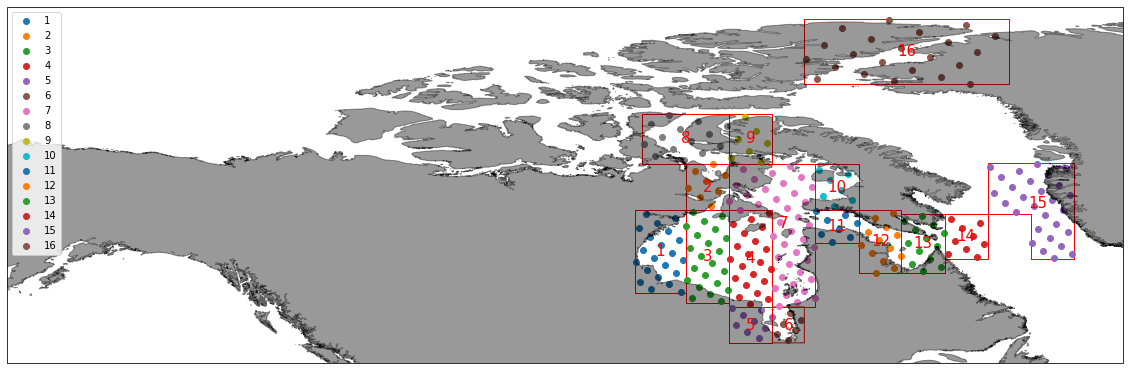

In [14]:

# marking the x-axis and y-axis  

fig=plt.figure(figsize=(20, 14), frameon=True)
# proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
proj=ccrs.PlateCarree()
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -46, 49, 84.7), crs=ccrs.PlateCarree())
# ax1.set_extent((-60, -55, 49, 84), crs=ccrs.PlateCarree())

# ax1.add_geometries([poly], crs=ccrs.PlateCarree(),  edgecolor='red', facecolor='None',alpha=1)
# ax1.scatter(modoceanlonpointvec,modoceanlatpointvec,transform=ccrs.PlateCarree(),s=3)

# cont1=ax1.scatter(vec[0,:],vec[1,:],c=vec[2,:],transform=ccrs.PlateCarree(),cmap='viridis',marker='o',vmin=1,vmax=17)
# cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
for keys in polydict:
    ax1.add_geometries([polydict[keys]],crs=ccrs.PlateCarree(),edgecolor='red',facecolor='None',label=keys)
    x=polydict[keys].centroid.x
    y=polydict[keys].centroid.y
    ax1.text(x, y, keys, color='red', size=15, ha='center', va='center', transform=ccrs.PlateCarree())
    #getting points in polygon. from paramid.
    indparam=np.where(vec[2,:]==keys)[0]
    print(vec)
    ax1.scatter(vec[0,indparam],vec[1,indparam],transform=ccrs.PlateCarree(),label=str(keys))

ax1.legend()

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
ax1.add_feature(feature)
    
plt.show()

In [15]:
fname='bf_correction_'+str(Npol)+'_v3.xyz'
sortind=np.argsort(paramid) #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((modoceanlonpointvec[sortind],modoceanlatpointvec[sortind]))
vec=np.vstack((vec,paramid[sortind].reshape((1,len(paramid)))))
#non 100 param value
paravec=vec[2,:]
inpolindex=np.where(paravec!=100) [0]
vec=vec[:,inpolindex]#removing the last point. as it is outside . point 100.
vec[2,:]=1.0  # initial multiplier value
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%d'],delimiter='\t')

Now instead of the above polygons we create a set of squares as polygons and compute the model runs for these squares to evaluate the sensitvities. 

In [7]:
Nlat=np.floor(abs((latmax-latmin)*0.25)).astype(int)
Nlon=np.floor(abs((lonmax-lonmin)*0.25)).astype(int)
latpointvec=np.linspace(latmin-0.5,latmax+0.5,Nlat)
lonpointvec=np.linspace(lonmin-0.5,lonmax+0.5,Nlon)
lonpointgrid,latpointgrid=np.meshgrid(lonpointvec,latpointvec)

polydict={}
k=1
i=0
float_formatter = "{:.2f}".format
while i<=(len(lonpointvec)-2):
    # print(i)
    j=0
    while j<=(len(latpointvec)-2):
        
        coords=[(lonpointvec[i], latpointvec[j]), (lonpointvec[i],latpointvec[j+1]), (lonpointvec[i+1],latpointvec[j+1]), (lonpointvec[i+1],latpointvec[j]),(lonpointvec[i],latpointvec[j])]
        npcoords=np.array(coords)
        poly=Polygon(coords)
        polydict[k]=poly
        j=j+1   
        k=k+1  
        
    i=i+1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
2
3
4
5
6
7
8
9
10


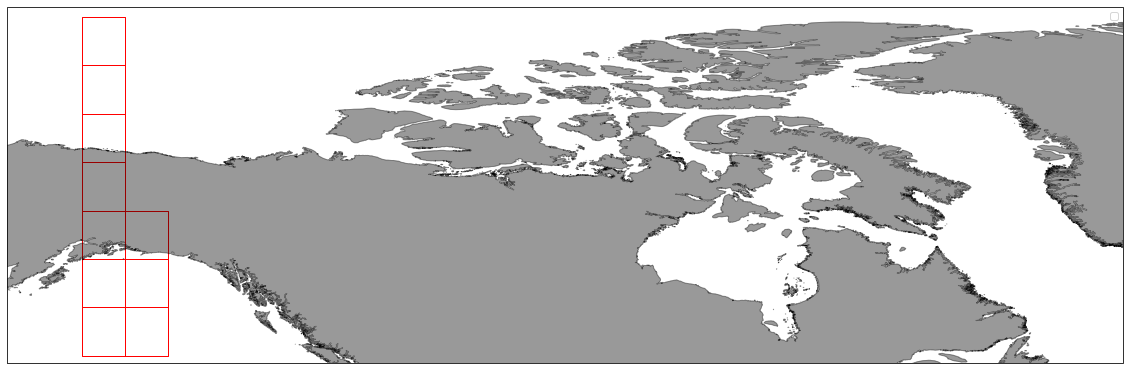

In [17]:

fig=plt.figure(figsize=(20, 14), frameon=True)
# proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
proj=ccrs.PlateCarree()
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -46, 49, 84.7), crs=ccrs.PlateCarree())

for i in list(polydict.keys())[:10]:
    print(i)
    ax1.add_geometries([polydict[i]],crs=ccrs.PlateCarree(),edgecolor='red',facecolor='None',label=keys)
    # x=polydict[keys].centroid.x
    # y=polydict[keys].centroid.y
    # ax1.text(x, y, keys, color='red', size=15, ha='center', va='center', transform=ccrs.PlateCarree())
    # #getting points in polygon. from paramid.
    # indparam=np.where(vec[2,:]==keys)[0]
    # print(vec)
    # ax1.scatter(vec[0,indparam],vec[1,indparam],transform=ccrs.PlateCarree(),label=str(keys))

ax1.legend()

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
ax1.add_feature(feature)
    
plt.show()

Based on the above polygon set we obtain .xyz files which are defined by the parameter ids.

In [18]:
#check if a point lies in a polygon. If so, assign the point a value of parameter corresponding to polygon id. 
paramid=[]
newpolydict={}
k=1
for i in range(len(modoceanlatpointvec)):
    point=Point(modoceanlonpointvec[i],modoceanlatpointvec[i])
    count=0
    
    for keys in polydict:
        poly=polydict[keys]
        if poly.contains(point):
            paramid=np.append(paramid,keys)
            # newpolydict[k]=poly
            count=1
            
    if count==0:
        #for points not in any polygon
        paramid=np.append(paramid,1000)
        # print('Point not contained in any polyon')
        # print(point)
    
    

In [19]:
print(paramid)

[ 113.  113.  106.  113.  162.  155.  106.  162.  113.  155.  113.  162.
  148.  106.  155.  113. 1000.  155.  106.  162.  148.  113.  106.  155.
  141.  113.  162.  148.  106.  162.  148.  113.   99.  155.  141.  113.
  162.  148.  120.  106.  155.  148.  113.  162.   99.  155.  141.  106.
  162.  148.  113.  106.  155.  142.  114.  163.  100.  149.  121.  107.
  156.  149.  114. 1000.  100.  156.  142.  107.  163.  100.  149.  121.
  107.  156.   93.  142.  114.  163.  100.  156.  142.  107.  163.   93.
  149.  114.  100.  156.   93.  142.  114.  163.  128.  100.  149.  121.
  142.  107.  156.   93.  149.  114.  163.  135.  100.  156.   86.  142.
  107.  163.  128.  100.  149.  114.  135.  107.  156.   93.  142.  114.
  163.  135.  100.  149.  121.   86.  142.  107.  163.  128.   93.  149.
  114.  135.  100.  156.   93.  142.  107.  163.  128.  100.  149.  121.
   86.  135.  107.  156.   93.  149.  114.  163.  135.  100.  156.   86.
  142.  107.  163.  128.   93.  149.  114.  135.  1

In [31]:
sortind=np.argsort(paramid)
paramid1=paramid[sortind]
print(sortind[0:5])
print(paramid[sortind[0:5]])
print(modoceanlonpointvec[sortind[0:5]],modoceanlatpointvec[sortind[0:5]])
print(modoceanlatpointvec[0:5])


[416 565 524 499 483]
[4. 5. 5. 5. 5.]
[-147.31513 -148.8602  -147.74218 -149.55118 -146.62416] [69.09418 73.53179 72.19827 71.42045 70.95511]
[50.24973 50.631   50.86816 51.25452 51.27632]


In [32]:
i=1 #parameter start.
newpolydict={}
sortind=np.argsort(paramid)
paramid1=paramid[sortind]
for keys in polydict:
    if keys in paramid1:
        # print(i)
        paramid1=np.where(paramid1==keys,i,paramid1)
        newpolydict[i]=polydict[keys]
        i=i+1


In [15]:
import pickle

In [16]:
#saving the newpolydict to nc or shape file
# Save polygon to disc

with open('./parampolygons', "wb") as poly_file:
    pickle.dump(newpolydict, poly_file, pickle.HIGHEST_PROTOCOL)



In [36]:
# print(paramid1)
print(modoceanlatpointvec[sortind],modoceanlonpointvec[sortind])

[69.09418 73.53179 72.19827 71.42045 70.95511 70.22445 69.51883 76.98474
 75.94714 77.66872 74.97972 74.41121 78.8627  81.12382 79.66834 82.86769
 68.67762 73.86224 71.24146 72.50424 73.01047 70.50047 71.71382 69.3557
 69.7856  76.3344  75.34192 78.11088 74.76021 80.19906 79.35362 83.65844
 81.74669 68.26867 67.86692 68.9342  70.0558  72.01181 73.33087 69.62044
 70.7803  72.81548 75.11719 78.56988 76.73274 77.40325 74.19941 75.7131
 79.86802 82.4202  80.7599  68.5206  67.47198 68.11445 73.13228 72.31466
 73.65737 71.53209 70.32955 69.1938  71.0641  77.83591 74.54374 77.14318
 76.09397 80.40966 81.35671 83.15929 79.04784 67.71534 67.0835  68.36467
 68.77537 72.6226  73.99034 71.35207 69.8885  69.45654 70.607   71.8272
 77.56693 76.48535 78.28429 75.48274 74.89573 81.99756 79.54734 69.0331
 67.96125 67.32291 71.64439 69.72253 73.45497 70.16004 72.93593 70.88833
 72.12702 75.25591 74.33019 75.85754 78.75026 76.88818 80.07166 82.69401
 80.98346 67.17476 68.2098  68.61767 73.25495 70.43519 

In [37]:
fname='densepara_correction_template_2.xyz'
# sortind=np.argsort(paramid) #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((modoceanlonpointvec[sortind],modoceanlatpointvec[sortind]))
vec=np.vstack((vec,paramid1.reshape((1,len(paramid1)))))
#non 100 param value
paravec=vec[2,:]
inpolindex=np.where(paravec!=1000) [0]
vec=vec[:,inpolindex]#removing the last point. as it is outside . point 100.
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%d'],delimiter='\t')

[[-147.31513 -148.8602  -147.74218 ...  -48.12259  -49.24062  -49.93159]
 [  69.09418   73.53179   72.19827 ...   69.90438   71.08093   69.20917]
 [   1.         2.         2.      ...  125.       125.       125.     ]]
[[-147.31513 -148.8602  -147.74218 ...  -48.12259  -49.24062  -49.93159]
 [  69.09418   73.53179   72.19827 ...   69.90438   71.08093   69.20917]
 [   1.         2.         2.      ...  125.       125.       125.     ]]
[[-147.31513 -148.8602  -147.74218 ...  -48.12259  -49.24062  -49.93159]
 [  69.09418   73.53179   72.19827 ...   69.90438   71.08093   69.20917]
 [   1.         2.         2.      ...  125.       125.       125.     ]]
[[-147.31513 -148.8602  -147.74218 ...  -48.12259  -49.24062  -49.93159]
 [  69.09418   73.53179   72.19827 ...   69.90438   71.08093   69.20917]
 [   1.         2.         2.      ...  125.       125.       125.     ]]
[[-147.31513 -148.8602  -147.74218 ...  -48.12259  -49.24062  -49.93159]
 [  69.09418   73.53179   72.19827 ...   69.904

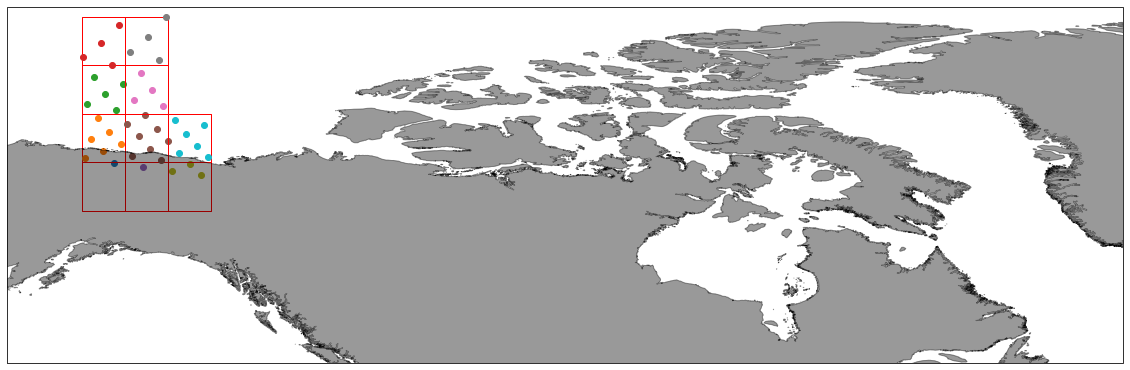

In [38]:
# marking the x-axis and y-axis  

fig=plt.figure(figsize=(20, 14), frameon=True)
# proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
proj=ccrs.PlateCarree()
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -46, 49, 84.7), crs=ccrs.PlateCarree())
# ax1.set_extent((-60, -55, 49, 84), crs=ccrs.PlateCarree())

for i in list(newpolydict.keys())[:10]:
    ax1.add_geometries([newpolydict[i]],crs=ccrs.PlateCarree(),edgecolor='red',facecolor='None',label=keys)
    # x=newpolydict[keys].centroid.x
    # y=newpolydict[keys].centroid.y
    # ax1.text(x, y, keys, color='red', size=15, ha='center', va='center', transform=ccrs.PlateCarree())
    #getting points in polygon. from paramid.
    indparam=np.where(vec[2,:]==i)[0]
    print(vec)
    ax1.scatter(vec[0,indparam],vec[1,indparam],transform=ccrs.PlateCarree(),label=str(keys))

# ax1.legend()

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
ax1.add_feature(feature)
    
plt.show()

In [39]:
fname='densepara_correction_2.xyz'
# sortind=np.argsort(paramid) #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((modoceanlonpointvec[sortind],modoceanlatpointvec[sortind]))
vec=np.vstack((vec,paramid1.reshape((1,len(paramid1)))))
#non 100 param value
paravec=vec[2,:]
inpolindex=np.where(paravec!=1000) [0]
vec=vec[:,inpolindex]#removing the last point. as it is outside . point 100.
vec[2,:]=1.0
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%0.2f'],delimiter='\t')


In [103]:
fname='paraval_0.2.xyz'
# sortind=np.argsort(paramid) #sorting based on paramid value.
#converting to a .xyz file

vec=paramid
inpolindex=np.where(vec!=1000) [0]

vec[:]=-0.2
vecstring=np.array2string(vec,separator=',')
# np.savetxt(fname,vec,fmt=['%0.2f'],delimiter='\t')
# np.savetxt(fname,np.array2string(vec))
with open(fname, 'w') as f:
    f.write(vecstring)

In [99]:
print(np.array2string(vec, separator=', '))

[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
 0.2, 0.2, 0

Now we check which points lie in sea ice cover and also if possible get concentration and other sea ice data. For this purpose, right now we use the nsidc data of sea ice cover etc and compue the tc_mid and fast from that. We process that separately (locally due ot issue in library installation on p drive. can be found at Research Data-ice-friction-analysis). The processed files are found in folder with names as *nh20130311* in NSIDC data folder. 

In [49]:
#get the projected buff file which gives us the polygon on ice cover. 
prjbuffile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/NSIDC_Icedata/nh_20130909/tc_mid/Buffer_proj.shp'
buffile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/NSIDC_Icedata/nh_20130909/tc_mid/Buffer.shp'
# reader=shapefile.Reader(buffile)
# multipol=shape(reader.shape())


In [50]:
import os

from osgeo import ogr
from osgeo import gdal
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
gdal.UseExceptions()
from pyproj import Proj, transform
from cartopy.feature import ShapelyFeature
import cmocean

/tmp/ipykernel_26728/1531578155.py:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  multi= multipol.next() # only one feature in the shapefile


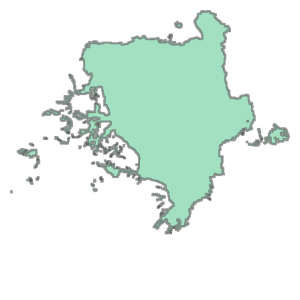

In [51]:

multipol = fiona.open(buffile)
multi= multipol.next() # only one feature in the shapefile
multipol=shape(multi['geometry'])
multipol
# print (multi['geometry'])

In [52]:
#check if a point lies in a polygon. If so, assign the point a value of parameter corresponding to polygon id. 
paramid=[]
inicelon=[];inicelat=[]
count=0
inProj = Proj(init='epsg:4326', preserve_units=True)
outProj = Proj(init='epsg:6931')
for i in range(len(modoceanlatpointvec))[:]:
    x2,y2 = transform(inProj,outProj,modoceanlonpointvec[i],modoceanlatpointvec[i])
    point=shape(Point(x2,y2))
    # print(point)
    if point.within(multipol.buffer(0)):
        # print(i)
        inicelon=np.append(inicelon,modoceanlonpointvec[i])
        inicelat=np.append(inicelat,modoceanlatpointvec[i])
        count+=1
 
        

/u/vasulkar/.conda/envs/plotting/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/u/vasulkar/.conda/envs/plotting/lib/python3.9/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/u/vasulkar/.conda/envs/plotting/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferre

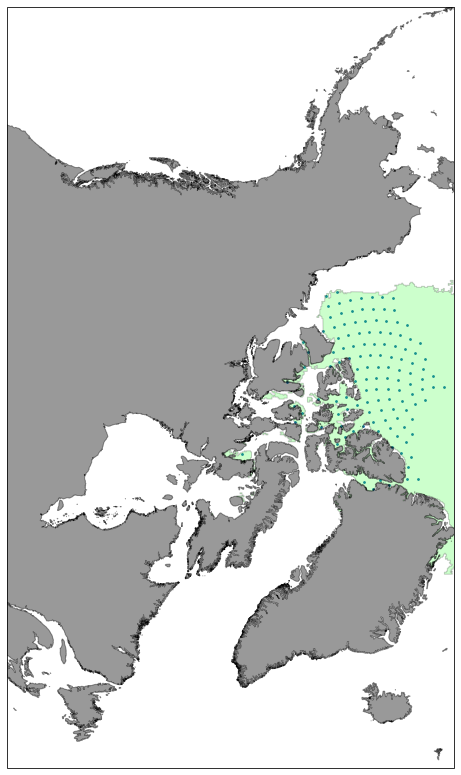

In [53]:
# marking the x-axis and y-axis  

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
# proj=ccrs.PlateCarree()
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -46, 49, 84.7), crs=ccrs.PlateCarree())
#
ax1.scatter(inicelon,inicelat,transform=ccrs.PlateCarree(),s=3)

shape_feature = ShapelyFeature(multipol.buffer(0), ccrs.LambertAzimuthalEqualArea(central_latitude=90.0), facecolor="lime", edgecolor='black',alpha=0.2)
ax1.add_feature(shape_feature)

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
ax1.add_feature(feature)
    
plt.show()

Now initially, we start with setting the calibration values of all the dots above as 1. 

In [54]:
fname='vis_correction_fb_Sep13.xyz'
 #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((inicelon,inicelat))
paramid=1.0*np.ones((len(inicelat)))
vec=np.vstack((vec,paramid.reshape((1,len(paramid)))))
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%0.2f'],delimiter='\t')

Now we do the same above thing for landfast ice. 

In [112]:
fibuffile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/NSIDC_Icedata/nh_20130114/fast/Buffer.shp'
multipol = fiona.open(fibuffile)
multi= multipol.next() # only one feature in the shapefile
multipol=shape(multi['geometry'])
multipol

<ipython-input-112-e5b7ff16d969>:3: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  multi= multipol.next() # only one feature in the shapefile


In [106]:
#check if a point lies in a polygon. If so, assign the point a value of parameter corresponding to polygon id. 
paramid=[]
inficelon=[];inficelat=[]
count=0
inProj = Proj(init='epsg:4326', preserve_units=True)
outProj = Proj(init='epsg:6931')
for i in range(len(modoceanlatpointvec))[:]:
    x2,y2 = transform(inProj,outProj,modoceanlonpointvec[i],modoceanlatpointvec[i])
    point=shape(Point(x2,y2))
    # print(point)
    if point.within(multipol.buffer(0)):
        # print(i)
        inficelon=np.append(inficelon,modoceanlonpointvec[i])
        inficelat=np.append(inficelat,modoceanlatpointvec[i])
        count+=1
 

/u/vasulkar/.conda/envs/plotting/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/u/vasulkar/.conda/envs/plotting/lib/python3.9/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/u/vasulkar/.conda/envs/plotting/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferre

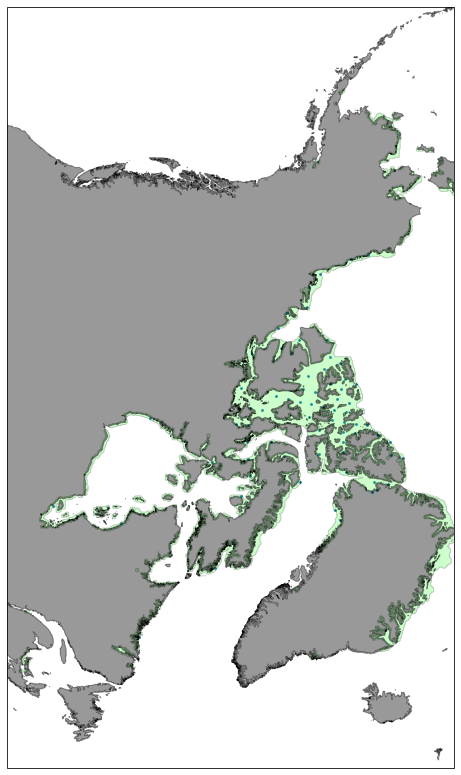

In [113]:
# marking the x-axis and y-axis  

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
# proj=ccrs.PlateCarree()
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -46, 49, 84.7), crs=ccrs.PlateCarree())
#
ax1.scatter(inficelon,inficelat,transform=ccrs.PlateCarree(),s=3)

shape_feature = ShapelyFeature(multipol.buffer(0), ccrs.LambertAzimuthalEqualArea(central_latitude=90.0), facecolor="lime", edgecolor='black',alpha=0.2)
ax1.add_feature(shape_feature)

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=0.4)
ax1.add_feature(feature)
    
plt.show()

In [108]:
fname='fice_coeff_correction_all.xyz'
 #sorting based on paramid value.
#converting to a .xyz file
vec=np.vstack((inficelon,inficelat))
paramid=1.0*np.ones((len(inficelat)))
vec=np.vstack((vec,paramid.reshape((1,len(paramid)))))
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%0.2f'],delimiter='\t')

Getting the ice thickness and ice concentration from CMEMS global ocean reanlaysis product. 
https://resources.marine.copernicus.eu/product-detail/GLOBAL_MULTIYEAR_PHY_001_030/INFORMATION

In [55]:
sitfile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/NSIDC_Icedata/CMEMS/cmems_mod_glo_phy_my_0.083_SIT.nc'
sitdata=xr.open_dataset(sitfile)
sitdata

<xarray.Dataset>
Dimensions:    (latitude: 541, longitude: 4320, time: 1)
Coordinates:
  * latitude   (latitude) float32 45.0 45.08 45.17 45.25 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2013-09-16
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
Data variables:
    sithick    (time, latitude, longitude) float32 ...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [56]:
sit=sitdata.sithick.values[0,:,:]
# print(sit)
sit=np.where((np.isnan(sit)==True),0,sit)
#may be smart to convert nan to 0?
# print(sit)

In [57]:
#interpolate the sit data to the points within the ice cover from NSIDC. 
fname='vis_correction_fb_Sep13.xyz'
headerlist=['Lon','Lat','pname']
df=pd.read_csv(fname,names=headerlist,delim_whitespace=True)
df.head()
ilon=df['Lon']
ilat=df['Lat']

In [58]:
from scipy.interpolate import NearestNDInterpolator 
#nearest interpolator is used because of a lot of nan values around. and interpolation really makes it smooth. which we don't want. 
interpfunc=NearestNDInterpolator(list(zip(sitdata.longitude.values,sitdata.latitude.values)),sit)
siti=interpfunc(ilon,ilat)
siti=siti[:,0]

Now we do the same for ice concentraion.

In [59]:
sicfile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/NSIDC_Icedata/CMEMS/cmems_mod_glo_phy_my_0.083_SIC.nc'
sicdata=xr.open_dataset(sicfile)
sicdata

<xarray.Dataset>
Dimensions:    (latitude: 541, longitude: 4320, time: 1)
Coordinates:
  * latitude   (latitude) float32 45.0 45.08 45.17 45.25 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2013-09-16
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
Data variables:
    siconc     (time, latitude, longitude) float32 ...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [61]:
sic=sicdata.siconc.values[0,:,:]
# print(sic)
sic=np.where((np.isnan(sic)==True),0,sic)
#may be smart to convert nan to 0?
# print(sic)

In [62]:
interpfunc=NearestNDInterpolator(list(zip(sicdata.longitude.values,sicdata.latitude.values)),sic)
sici=interpfunc(ilon,ilat)
#1d vec
sici=sici[:,0]


Now where the sic is 

Now using the sic and sit values at these point we compute the viscosity eta. And then divide that by H (bathymetry)

In [63]:
#shear and bulk viscosities of sea ice EVP and shiming yu ppt
#standard values.
P_s=25.
deltao=2e-09
e=2.
rhoi=920.
C=20.


In [64]:
#Start by computing P
#P=P_s*h*np.exp(-C(1-A))
Pvec=[]
for i in range(len(siti)):
    h=siti[i]
    A=sici[i]
    if (A>0.0) and (h>0.0):
        P=P_s*h*np.exp(-C*(1-A))
        Pvec=np.append(Pvec,P)
    else:
        Pvec=np.append(Pvec,0)

etaivec=Pvec/(2*deltao*e**2)
# etam=etai/(H*rhoi)
print(etaivec)
# print(zeta)

[0.00000000e+00 8.61911934e+08 4.24307792e+08 1.35077228e+09
 1.20253589e+09 0.00000000e+00 8.82281865e+08 1.29085894e+09
 1.69891651e+09 4.42858749e+08 1.51124158e+09 0.00000000e+00
 1.39902504e+09 0.00000000e+00 2.67254154e+08 1.41055714e+09
 0.00000000e+00 9.07261318e+08 1.17738644e+08 1.37125849e+09
 0.00000000e+00 4.78432494e+08 1.53986006e+09 1.07674437e+04
 1.41009799e+09 1.22260268e+09 3.21419940e+08 1.42987109e+09
 3.43462229e+00 0.00000000e+00 9.88571390e+08 0.00000000e+00
 1.33002913e+09 1.67283381e+08 1.41355406e+09 0.00000000e+00
 5.51142518e+08 1.54914033e+09 0.00000000e+00 1.02924582e+05
 1.43391384e+09 1.33937904e+09 3.67701882e+08 1.46174297e+09
 1.06120335e+09 0.00000000e+00 1.29843924e+09 1.85091370e+08
 1.37538139e+09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.03255806e+08 0.00000000e+00 1.55100457e+09 0.00000000e+00
 4.09756138e+06 0.00000000e+00 1.33911407e+09 0.00000000e+00
 1.40468972e+09 0.00000000e+00 3.81427867e+08 1.49558721e+09
 0.00000000e+00 1.239513

get bathymetry from canada model. 

In [65]:
netcanda='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/basic_test_model/stochModel/input_model/gtsm__canada_2_net.nc'
netdata=xr.open_dataset(netcanda)
netdata

<xarray.Dataset>
Dimensions:      (nNetLink: 560343, nNetLinkPts: 2, nNetNode: 278376)
Coordinates:
    NetNode_x    (nNetNode) float64 ...
    NetNode_y    (nNetNode) float64 ...
Dimensions without coordinates: nNetLink, nNetLinkPts, nNetNode
Data variables:
    Mesh2D       int32 ...
    wgs84        int32 ...
    NetNode_z    (nNetNode) float64 ...
    NetLink      (nNetLink, nNetLinkPts) int32 ...
    NetLinkType  (nNetLink) int32 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.59.64338M, Jul 19 2019, 1...
    history:        Created on 2021-07-21T17:40:42+0200, D-Flow FM
    date_created:   2021-07-21T17:40:42+0200
    date_modified:  2021-07-21T17:40:42+0200
    Conventions:    UGRID-0.9

In [66]:
netx=netdata.NetNode_x.values
nety=netdata.NetNode_y.values
Hbathy=netdata.NetNode_z.values
interpfunc=NearestNDInterpolator(list(zip(netx,nety)),Hbathy)
Hvec=interpfunc(ilon,ilat)
#1d vec
# sici=sici[:,0]

In [67]:
etaiavgvec=-etaivec/(Hvec*rhoi)
print(etaiavgvec)

[ 0.00000000e+00  3.35414913e+03  2.30264957e+02  1.15049925e+03
  1.43849880e+04  0.00000000e+00  3.94056531e+02  9.01080863e+02
  1.98980356e+04  1.64984048e+02  4.57546665e+04  0.00000000e+00
  5.89717712e+02  0.00000000e+00  8.43683256e+01  2.90008595e+03
  0.00000000e+00  3.16972924e+02  3.47842758e+01  5.50272061e+02
  0.00000000e+00  1.46979149e+02  4.73233410e+03  3.10019890e-03
  4.74354461e+02  2.73129785e+03  9.38812335e+01  1.40009772e+03
  9.65629407e-07  0.00000000e+00  3.05273378e+02  0.00000000e+00
  3.49443349e+03  4.79111750e+01  4.62420136e+02  0.00000000e+00
  1.61076573e+02  2.61441392e+03  0.00000000e+00  2.92471813e-02
  4.39301407e+02  2.13542023e+04  1.05716372e+02  5.51891925e+02
  3.13029187e+02  0.00000000e+00  1.41705933e+03  5.28999938e+01
  4.15976099e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.02377167e+02  0.00000000e+00  5.73541560e+02  0.00000000e+00
  1.15966339e+00  0.00000000e+00  3.95892648e+02  0.00000000e+00
  1.14832716e+03  0.00000

In [68]:
fname='vis_val_fb_Sept2013.xyz'

vec=np.vstack((ilon,ilat))
vec=np.vstack((vec,etaiavgvec.reshape((1,len(etaiavgvec)))))
# vec=vec[:,:-2]#removing the last point. as it is outside . point 100.
# vec[2,:]=1.0 #starting with 1.0 as the multiplier.
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%0.3f'],delimiter='\t')

In [43]:
def interpnan(A):
    # A=siti[:,0]
    ok = ~np.isnan(A)
    xp = ok.ravel().nonzero()[0]
    fp = A[~np.isnan(A)]
    x  = np.isnan(A).ravel().nonzero()[0]

    A[np.isnan(A)] = np.interp(x, xp, fp)
    return(A)

#obtained from stackoverflow
#https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array 

Now we create .xml files of stochmodel and wrapper based on parameterization. 

In [5]:
import xml.etree.ElementTree as ET

In [13]:
bfparams=12
bathyparams=17
Nparams=bfparams+bathyparams

In [6]:
stochmodfloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/Canadamodel_1/stochModel/'
stochmodfile=stochmodfloc+'StochModel_template.xml'

In [11]:
# newxmlfile=newtgfileloc+'noosObsfile.xml'
# shutil.copy2(tempxmlfile,newxmlfile)
tree=ET.parse(stochmodfile)
root=tree.getroot()
print(root)
for elem in root[1]:
    print(elem)
    print(elem.attrib)
    print(elem.text)

<Element '{http://www.openda.org}blackBoxStochModel' at 0x7f838710ce00>
<Element '{http://www.openda.org}parameters' at 0x7f838709a130>
{}


            
<Element '{http://www.openda.org}predictor' at 0x7f838709a400>
{}

            


In [ ]:
def editregconst(root,idstr,i,covval):
    paraid=idstr+str(i+1)
    attrib1={}
    ET.SubElement(root[1][0],'regularisationConstant',attrib1)
    attrib1={'transformation':"identity",'value':covval}
    ET.SubElement(root[1][0][i],'stdDev',attrib1)
    #subelem2
    attrib2={'id':paraid}
    ET.SubElement(root[1][0][i],'vector',attrib2)

In [12]:
root[1][0].remove(root[1][0][0])
for i in range(Nparams):
    if i<12:
        idstr='bf_'
        covval="0.2"
        editregconst(root,idstr,i,covval)
    else:
        idstr='depth_'
        covval="0.05"
        editregconst(root,idstr,i-12,covval)
root[1][1].remove(root[1][1][0])

